In [152]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import datetime
import random
import pickle
import networkx as nx
import itertools
import math

In [153]:
df = pd.read_csv("modified_datasets/stock_ticks")
df = df.set_index('Date')

In [154]:
# set seed for repeatibility
np.random.seed(1000)
random.seed(1000)

# user settings
number_of_mutations = 1000

In [189]:
def view_graph(symbol_list, graph_as_list, title, filename):
    DG = nx.DiGraph()
    for i in symbol_list:
        DG.add_node(i)
    for n in graph_as_list:
        i = n.split('_')[0]
        j = n.split('_')[1]
        value = int(n.split('_')[2])
        if value == 1:
            DG.add_edge(i, j)

    #import matplotlib.pyplot as plt
    #nx.draw_networkx(DG, alpha=0.2, node_color='orange')
    #plt.title(title)
    #plt.axis('off')
    #plt.show()

    nx.draw_networkx(DG,font_size=6, node_size = 200, node_color='yellow', figsize=(150,150))
    nx.drawing.nx_pydot.write_dot(DG, filename)
    #nx.draw_graphviz(DG)


In [156]:
def gm_returns(col):
    gm_returns = np.log(df[col]).diff()
    #gm_returns.plot()
    return gm_returns

In [157]:
def am_returns(col):
    am_returns = (df[col]-df[col].shift(1))/df[col].shift(1)
    return am_returns

In [158]:
df_returns = pd.DataFrame()
for col in df.columns:
    new_col = col[:-6]
    df_returns[new_col] = am_returns(col).iloc[1:]

In [159]:
symbol_list = list(df_returns.columns)

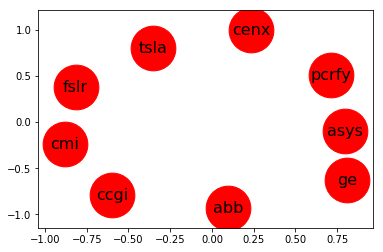

In [173]:
graph_as_list = []
for i in symbol_list:
    for j in symbol_list:
        if i == j:  continue
        graph_as_list.append(i + '_' + j + '_0')
view_graph(symbol_list, graph_as_list, 'Initial Bayesian Network of DJIA Stocks\' Change in Closing Prices', './output/initial_graph.dot')

In [ ]:
def score_graph(G, pd):

    # used later for penalizing graphs with many connections
    direction_zero_count = 0

    # identify the parents of each child node
    parents = {}
    for node in G:
        i = node.split('_')[0]
        j = node.split('_')[1]
        direction = node.split('_')[2]
        if not j in parents:  parents[j] = []
        if direction == '0':  
            direction_zero_count += 1
            continue
        if direction == '1':  parents[j].append(i)

    # compute probabilities of each node given parent nodes
    probs = {}
    for child in sorted(parents.keys()):

        # denominator (this is the probability of the "given" side of the conditional probability)
        DENOMINATOR = {}
        sets = []
        parent_list = []
        parent_list_index = []
        for parent in sorted(parents[child]):
            parent_list.append(parent)
            parent_list_index.append(symbol_list.index(parent))
            sets.append(['0', '1'])
        cases = []
        for i in itertools.product(*sets):
            cases.append(list(i))
        for case in cases:
            denominator = 0.
            for pd1 in pd.keys():
                pd1 = pd1.split(',')
                all_match = True
                for i, pli in enumerate(parent_list_index):
                    if case[i] != pd1[pli]:
                        all_match = False
                if all_match:  denominator += pd[','.join(pd1)]
            DENOMINATOR[','.join(case)] = denominator
            
            # return from function if denominator is zero
            if denominator == 0.0:
                return -99999999999999.0, {}, {}
        
        # data structure for storing the conditional probability of each node
        probs[child] = {}

        # numerator (this is the probability of the event and the "given" side of the conditional probability
        sets = []
        all_list = []
        all_list_index = []
        all_list_symbols = [child]
        all_list_symbols.extend(sorted(parents[child]))
        for all_item in all_list_symbols:
            all_list.append(all_item)
            all_list_index.append(symbol_list.index(all_item))
            sets.append(['0', '1'])
        cases = []
        for i in itertools.product(*sets):
            cases.append(list(i))
        for case in cases:
            numerator = 0.
            for pd1 in pd.keys():
                pd1 = pd1.split(',')
                all_match = True
                for i, pli in enumerate(all_list_index):
                    if case[i] != pd1[pli]:
                        all_match = False
                if all_match:
                    numerator += pd[','.join(pd1)]
            probs[child][','.join(case)] = numerator / DENOMINATOR[','.join(case[1:])]

    # score each pd element
    BN_dict = {}
    BN_list = []
    SBN_dict = {}
    SBN_list = []
    for pds in pd.keys():
        pds = pds.split(',')
        BN = 1.
        for i in range(0, len(pds)):
            symbol = symbol_list[i]
            parent_list = sorted(parents[symbol])
            parent_indexes = [symbol_list.index(x) for x in parent_list]

            case = [pds[i]]
            case.extend([pds[x] for x in parent_indexes])
            case = ','.join(case)

            BN = BN * probs[symbol][case]

        BN_dict[','.join(pds)] = BN
        BN_list.append(BN)
        SBN_dict[','.join(pds)] = math.log10(BN)
        SBN_list.append(math.log10(BN))

    # this is the probability of the graph, used to penalize graphs with high number of edges
    graph_prob = math.log10(float(direction_zero_count) / float(len(G)))

    return sum(SBN_list) + graph_prob, BN_dict, SBN_dict

In [ ]:
MOVEMENT_LEVELS=[]
for index,row in df_returns.iterrows():
    movement_temp =[]
    row_mean = row.mean()
    for col in df_returns.columns:
        if row[col]>=row_mean:
            movement_temp.append(1)
        else:
            movement_temp.append(0)
    MOVEMENT_LEVELS.append(movement_temp)

In [161]:
# see if there are duplicate movement levels and assign probability to level combination
movement_levels_dict = {}
for e in MOVEMENT_LEVELS:
    e = [str(x) for x in e]
    if not (','.join(e)) in movement_levels_dict:
        movement_levels_dict[','.join(e)] = 0
    movement_levels_dict[','.join(e)] += 1
prob_dict = {}
for e in movement_levels_dict.keys():
    prob_dict[e] = movement_levels_dict[e] * (1. / len(MOVEMENT_LEVELS))

In [175]:
# iterate
score, BN_d, SBN_d = score_graph(graph_as_list, prob_dict)
BN_d_storage = {}
SBN_d_storage = {}
for i in range(0, number_of_mutations):

    old_graph = graph_as_list
    new_graph = [x for x in old_graph]

    # possibly activate or disactivate an edge to form a new graph
    edge = random.sample(graph_as_list, 1)[0]
    edge_index = old_graph.index(edge)
    r = random.uniform(0, 1)
    direction = '0'
    if r >= 0.5:  direction = '1'
    new_edge = edge.split('_')[0:2]
    new_edge.append(direction)
    new_graph[edge_index] = '_'.join(new_edge)

    # evaluate the new model
    test_score, BN_d, SBN_d = score_graph(new_graph, prob_dict)
    if test_score > score:
        score = test_score
        graph_as_list = new_graph
        BN_d_storage = BN_d
        SBN_d_storage = SBN_d
    else:
        graph_as_list = old_graph

    print('Iteration:', i, '  Score:', score)

('Iteration:', 0, '  Score:', -1100.29881831371)
('Iteration:', 1, '  Score:', -1100.29881831371)
('Iteration:', 2, '  Score:', -1100.29881831371)
('Iteration:', 3, '  Score:', -1100.29881831371)
('Iteration:', 4, '  Score:', -1100.29881831371)
('Iteration:', 5, '  Score:', -1100.29881831371)
('Iteration:', 6, '  Score:', -1100.29881831371)
('Iteration:', 7, '  Score:', -1100.29881831371)
('Iteration:', 8, '  Score:', -1100.29881831371)
('Iteration:', 9, '  Score:', -1100.29881831371)
('Iteration:', 10, '  Score:', -1100.29881831371)
('Iteration:', 11, '  Score:', -1100.29881831371)
('Iteration:', 12, '  Score:', -1100.29881831371)
('Iteration:', 13, '  Score:', -1100.2002901938654)
('Iteration:', 14, '  Score:', -1100.2002901938654)
('Iteration:', 15, '  Score:', -1100.2002901938654)
('Iteration:', 16, '  Score:', -1100.2002901938654)
('Iteration:', 17, '  Score:', -1100.2002901938654)
('Iteration:', 18, '  Score:', -1100.2002901938654)
('Iteration:', 19, '  Score:', -1100.20029019386

('Iteration:', 157, '  Score:', -1098.5902960802468)
('Iteration:', 158, '  Score:', -1098.5902960802468)
('Iteration:', 159, '  Score:', -1098.5902960802468)
('Iteration:', 160, '  Score:', -1098.5902960802468)
('Iteration:', 161, '  Score:', -1098.5902960802468)
('Iteration:', 162, '  Score:', -1098.5902960802468)
('Iteration:', 163, '  Score:', -1098.5902960802468)
('Iteration:', 164, '  Score:', -1098.5902960802468)
('Iteration:', 165, '  Score:', -1098.5902960802468)
('Iteration:', 166, '  Score:', -1098.5902960802468)
('Iteration:', 167, '  Score:', -1098.4857858845535)
('Iteration:', 168, '  Score:', -1098.4857858845535)
('Iteration:', 169, '  Score:', -1098.4857858845535)
('Iteration:', 170, '  Score:', -1098.4857858845535)
('Iteration:', 171, '  Score:', -1098.4857858845535)
('Iteration:', 172, '  Score:', -1098.4857858845535)
('Iteration:', 173, '  Score:', -1098.4857858845535)
('Iteration:', 174, '  Score:', -1098.4857858845535)
('Iteration:', 175, '  Score:', -1098.48578588

('Iteration:', 314, '  Score:', -1096.6767708727666)
('Iteration:', 315, '  Score:', -1096.6767708727666)
('Iteration:', 316, '  Score:', -1096.6767708727666)
('Iteration:', 317, '  Score:', -1096.6767708727666)
('Iteration:', 318, '  Score:', -1096.6767708727666)
('Iteration:', 319, '  Score:', -1096.6767708727666)
('Iteration:', 320, '  Score:', -1096.6767708727666)
('Iteration:', 321, '  Score:', -1096.6767708727666)
('Iteration:', 322, '  Score:', -1096.6767708727666)
('Iteration:', 323, '  Score:', -1096.6767708727666)
('Iteration:', 324, '  Score:', -1096.2431837583513)
('Iteration:', 325, '  Score:', -1096.1425071967712)
('Iteration:', 326, '  Score:', -1096.1425071967712)
('Iteration:', 327, '  Score:', -1096.1425071967712)
('Iteration:', 328, '  Score:', -1096.1425071967712)
('Iteration:', 329, '  Score:', -1096.1425071967712)
('Iteration:', 330, '  Score:', -1096.1425071967712)
('Iteration:', 331, '  Score:', -1096.1425071967712)
('Iteration:', 332, '  Score:', -1096.14250719

('Iteration:', 472, '  Score:', -1096.1425071967712)
('Iteration:', 473, '  Score:', -1096.1425071967712)
('Iteration:', 474, '  Score:', -1096.1425071967712)
('Iteration:', 475, '  Score:', -1096.1425071967712)
('Iteration:', 476, '  Score:', -1096.1425071967712)
('Iteration:', 477, '  Score:', -1096.1425071967712)
('Iteration:', 478, '  Score:', -1096.1425071967712)
('Iteration:', 479, '  Score:', -1096.1425071967712)
('Iteration:', 480, '  Score:', -1096.1425071967712)
('Iteration:', 481, '  Score:', -1096.1425071967712)
('Iteration:', 482, '  Score:', -1096.1425071967712)
('Iteration:', 483, '  Score:', -1096.1425071967712)
('Iteration:', 484, '  Score:', -1096.1425071967712)
('Iteration:', 485, '  Score:', -1096.1425071967712)
('Iteration:', 486, '  Score:', -1096.1425071967712)
('Iteration:', 487, '  Score:', -1096.1425071967712)
('Iteration:', 488, '  Score:', -1096.1425071967712)
('Iteration:', 489, '  Score:', -1096.1425071967712)
('Iteration:', 490, '  Score:', -1096.14250719

('Iteration:', 627, '  Score:', -1096.0440956774648)
('Iteration:', 628, '  Score:', -1096.0440956774648)
('Iteration:', 629, '  Score:', -1096.0440956774648)
('Iteration:', 630, '  Score:', -1096.0440956774648)
('Iteration:', 631, '  Score:', -1096.0440956774648)
('Iteration:', 632, '  Score:', -1096.0440956774648)
('Iteration:', 633, '  Score:', -1096.0440956774648)
('Iteration:', 634, '  Score:', -1096.0440956774648)
('Iteration:', 635, '  Score:', -1096.0440956774648)
('Iteration:', 636, '  Score:', -1096.0440956774648)
('Iteration:', 637, '  Score:', -1096.0440956774648)
('Iteration:', 638, '  Score:', -1096.0440956774648)
('Iteration:', 639, '  Score:', -1096.0440956774648)
('Iteration:', 640, '  Score:', -1096.0440956774648)
('Iteration:', 641, '  Score:', -1096.0440956774648)
('Iteration:', 642, '  Score:', -1096.0440956774648)
('Iteration:', 643, '  Score:', -1096.0440956774648)
('Iteration:', 644, '  Score:', -1096.0440956774648)
('Iteration:', 645, '  Score:', -1096.04409567

('Iteration:', 784, '  Score:', -1096.031118605064)
('Iteration:', 785, '  Score:', -1096.031118605064)
('Iteration:', 786, '  Score:', -1096.031118605064)
('Iteration:', 787, '  Score:', -1096.031118605064)
('Iteration:', 788, '  Score:', -1096.031118605064)
('Iteration:', 789, '  Score:', -1096.031118605064)
('Iteration:', 790, '  Score:', -1096.031118605064)
('Iteration:', 791, '  Score:', -1096.031118605064)
('Iteration:', 792, '  Score:', -1096.031118605064)
('Iteration:', 793, '  Score:', -1096.031118605064)
('Iteration:', 794, '  Score:', -1096.031118605064)
('Iteration:', 795, '  Score:', -1096.031118605064)
('Iteration:', 796, '  Score:', -1096.031118605064)
('Iteration:', 797, '  Score:', -1096.031118605064)
('Iteration:', 798, '  Score:', -1096.031118605064)
('Iteration:', 799, '  Score:', -1096.031118605064)
('Iteration:', 800, '  Score:', -1096.031118605064)
('Iteration:', 801, '  Score:', -1096.031118605064)
('Iteration:', 802, '  Score:', -1096.031118605064)
('Iteration:

('Iteration:', 941, '  Score:', -1095.2536055197713)
('Iteration:', 942, '  Score:', -1095.2536055197713)
('Iteration:', 943, '  Score:', -1095.2536055197713)
('Iteration:', 944, '  Score:', -1095.2536055197713)
('Iteration:', 945, '  Score:', -1095.2536055197713)
('Iteration:', 946, '  Score:', -1095.2536055197713)
('Iteration:', 947, '  Score:', -1095.2536055197713)
('Iteration:', 948, '  Score:', -1095.2536055197713)
('Iteration:', 949, '  Score:', -1095.2536055197713)
('Iteration:', 950, '  Score:', -1095.2536055197713)
('Iteration:', 951, '  Score:', -1095.2536055197713)
('Iteration:', 952, '  Score:', -1095.2536055197713)
('Iteration:', 953, '  Score:', -1095.2536055197713)
('Iteration:', 954, '  Score:', -1095.2536055197713)
('Iteration:', 955, '  Score:', -1095.2536055197713)
('Iteration:', 956, '  Score:', -1095.2536055197713)
('Iteration:', 957, '  Score:', -1095.2536055197713)
('Iteration:', 958, '  Score:', -1095.2536055197713)
('Iteration:', 959, '  Score:', -1095.25360551

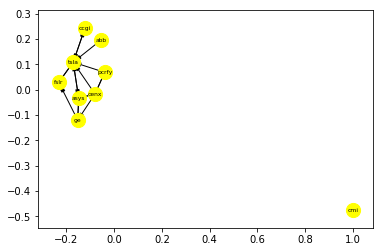

In [197]:
view_graph(symbol_list, graph_as_list, 'Learned Bayesian Network of DJIA Stocks\' Change in Closing Prices', 'output/final_graph.dot')


In [193]:
def edit_graph(filename):
    f = open(filename)
    new_graph = ''
    for line in f:
        line = line.strip()
        if line != '}':  
            new_graph += line.replace(';', ' [arrowsize=2.0];') + '\n'
    f.close()
    for symbol in symbol_list:
        new_graph += symbol + ' [color=orange, style=filled, fontsize=30];\n'
    new_graph += '}'
    f_out = open(filename + '_EDITED', 'w')
    f_out.write(new_graph + '\n')
    f_out.close()

edit_graph('output/initial_graph.dot')
edit_graph('output/final_graph.dot')


In [16]:
graph_as_list

['abb_asys_0',
 'abb_ccgi_0',
 'abb_cenx_0',
 'abb_cmi_0',
 'abb_fslr_0',
 'abb_ge_0',
 'abb_pcrfy_0',
 'abb_tsla_1',
 'asys_abb_0',
 'asys_ccgi_0',
 'asys_cenx_1',
 'asys_cmi_0',
 'asys_fslr_0',
 'asys_ge_1',
 'asys_pcrfy_0',
 'asys_tsla_1',
 'ccgi_abb_0',
 'ccgi_asys_0',
 'ccgi_cenx_0',
 'ccgi_cmi_0',
 'ccgi_fslr_0',
 'ccgi_ge_0',
 'ccgi_pcrfy_0',
 'ccgi_tsla_1',
 'cenx_abb_0',
 'cenx_asys_1',
 'cenx_ccgi_0',
 'cenx_cmi_0',
 'cenx_fslr_0',
 'cenx_ge_1',
 'cenx_pcrfy_1',
 'cenx_tsla_1',
 'cmi_abb_0',
 'cmi_asys_0',
 'cmi_ccgi_0',
 'cmi_cenx_0',
 'cmi_fslr_0',
 'cmi_ge_0',
 'cmi_pcrfy_0',
 'cmi_tsla_0',
 'fslr_abb_0',
 'fslr_asys_0',
 'fslr_ccgi_0',
 'fslr_cenx_0',
 'fslr_cmi_0',
 'fslr_ge_0',
 'fslr_pcrfy_0',
 'fslr_tsla_1',
 'ge_abb_0',
 'ge_asys_1',
 'ge_ccgi_0',
 'ge_cenx_0',
 'ge_cmi_0',
 'ge_fslr_1',
 'ge_pcrfy_0',
 'ge_tsla_0',
 'pcrfy_abb_0',
 'pcrfy_asys_0',
 'pcrfy_ccgi_0',
 'pcrfy_cenx_1',
 'pcrfy_cmi_0',
 'pcrfy_fslr_0',
 'pcrfy_ge_0',
 'pcrfy_tsla_1',
 'tsla_abb_0',
 'tsla

In [17]:
new_df = pd.DataFrame()
new_df['tsla']= df_returns['tsla']
new_df['abb']= df_returns['abb']

In [133]:
from pydlm import dlm, trend, seasonality

time_series =df_returns['tsla']

linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=72, discount=0.99, name='seasonal52', w=10)
# Build a simple dlm
simple_dlm = dlm(time_series) + linear_trend + seasonal52

Initializing models...
Initialization finished.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


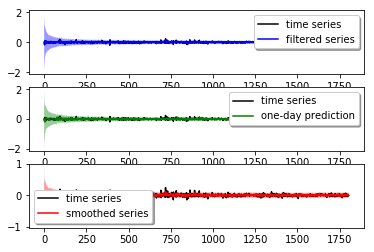

In [134]:
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

In [135]:
simple_dlm.getMSE()

0.0016620324002070378

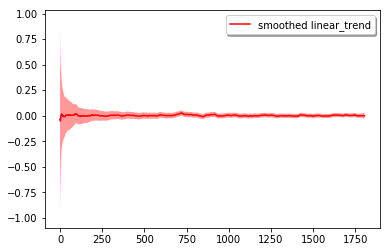

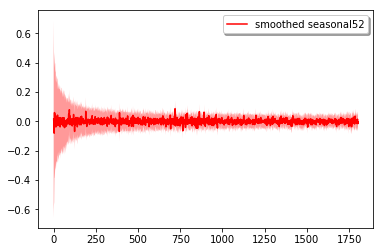

In [136]:
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal52')


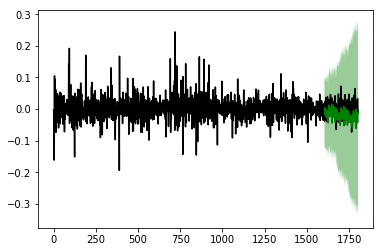

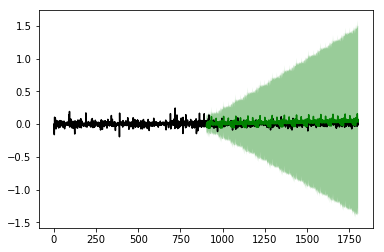

In [137]:
simple_dlm.plotPredictN(date=1604, N=200)
simple_dlm.plotPredictN(date=904, N=900)



In [212]:
features = [[df_returns['abb'].iloc[i], df_returns['asys'].iloc[i], df_returns['ccgi'].iloc[i], df_returns['cenx'].iloc[i], df_returns['fslr'].iloc[i]]  for i in range(1804) ]
from pydlm import dynamic
linear_trend2 = trend(degree=1, discount=0.95, name='linear_trend', w=10)
regressor10 = dynamic(features=features, discount=1.0, name='regressor10', w=10)
drm = dlm(time_series) + linear_trend2 + seasonal52 + regressor10


In [213]:
drm.fit()
drm.getMSE()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


0.0015283137102492651

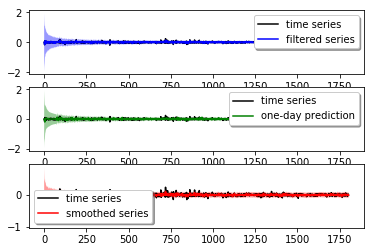

In [214]:
drm.turnOff('data points')
drm.plot()

In [ ]:
drm.turnOff('predict plot')
drm.turnOff('filtered plot')
drm.plot('linear_trend')
drm.plot('seasonal52')
drm.plot('regressor10')

In [ ]:
simple_dlm.plotPredictN(date=1604, N=200)
simple_dlm.plotPredictN(date=904, N=900)




In [ ]:
drm.ls()

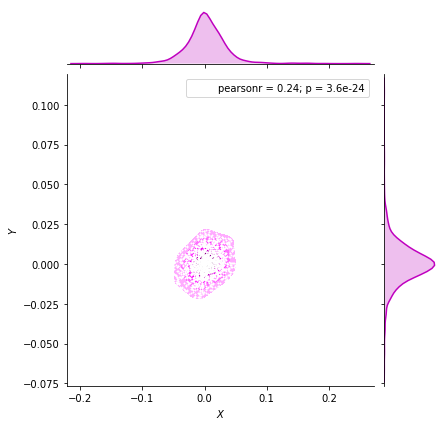

In [146]:
g = sns.jointplot(x="tsla", y="ge", data=df_returns, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=3, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

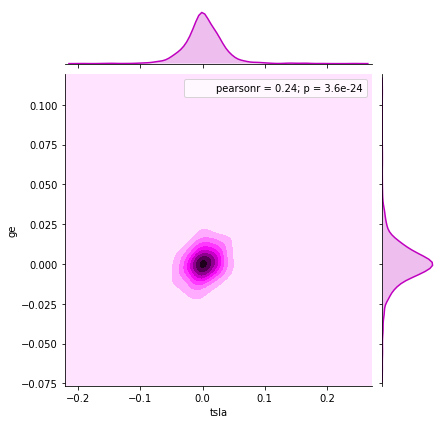

In [147]:
sns.jointplot(x="tsla", y="ge", data=df_returns, kind="kde", color="m")

